<a href="https://colab.research.google.com/github/NL364/Time-Series/blob/main/notebooks/tf2/time-series-rnn-full-predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Time Series data

* Idea and some code taken from, and also OPSD time series data set explained here: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* Some code and approaches from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* Nice tutorial: https://www.tensorflow.org/beta/tutorials/text/time_series

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [2]:
import pandas as pd
import numpy as np

In [4]:
# for local
# url = 'HopeStreet_Monthly_Readings.csv'

# for colab
url = 'https://raw.githubusercontent.com/NL364/Time-Series/main/Hope%20Street%20daily%20data%202021-2023.csv'

time_series_df = pd.read_csv(url,
                             sep=',',
                             index_col=0, # you can use the date as the index for pandas
                             parse_dates=['Date'], dayfirst=True)


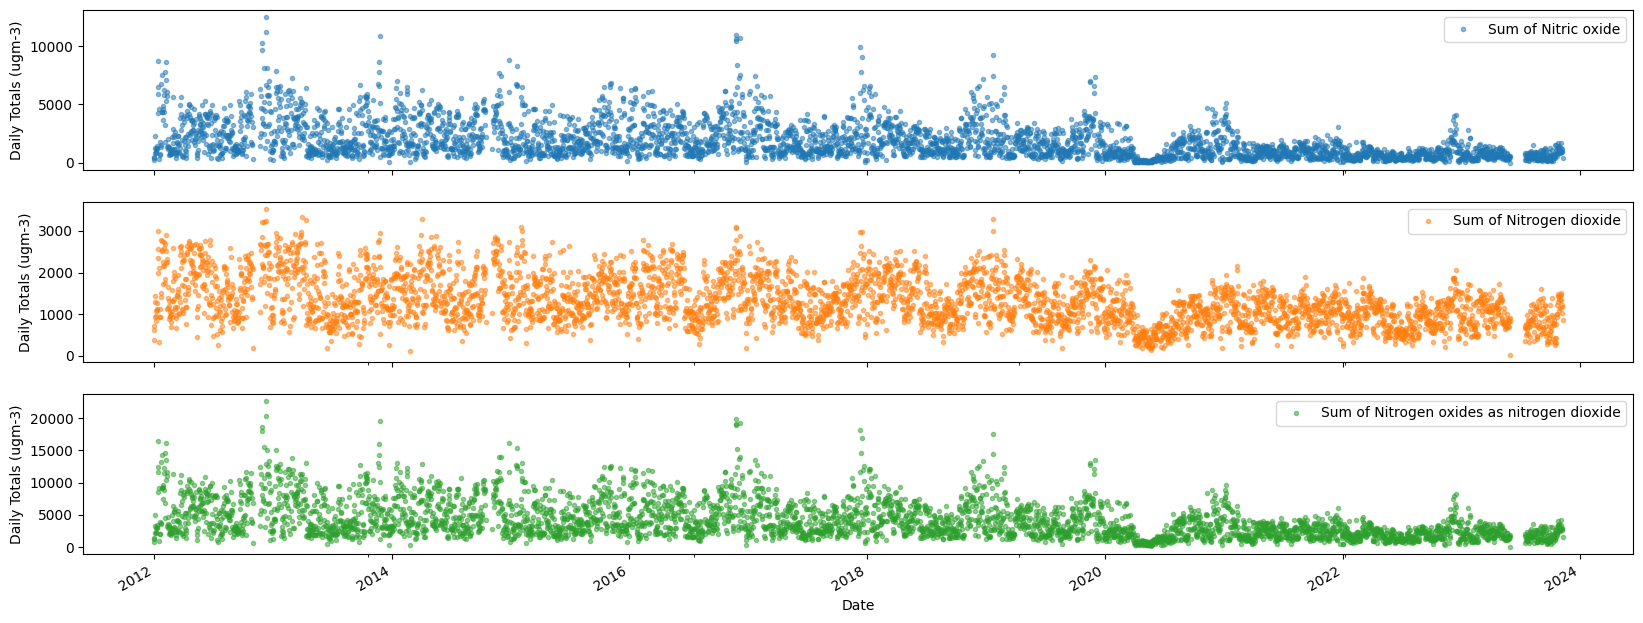

In [5]:
cols_plot = ['Sum of Nitric oxide', 'Sum of Nitrogen dioxide', 'Sum of Nitrogen oxides as nitrogen dioxide']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (ugm-3)')

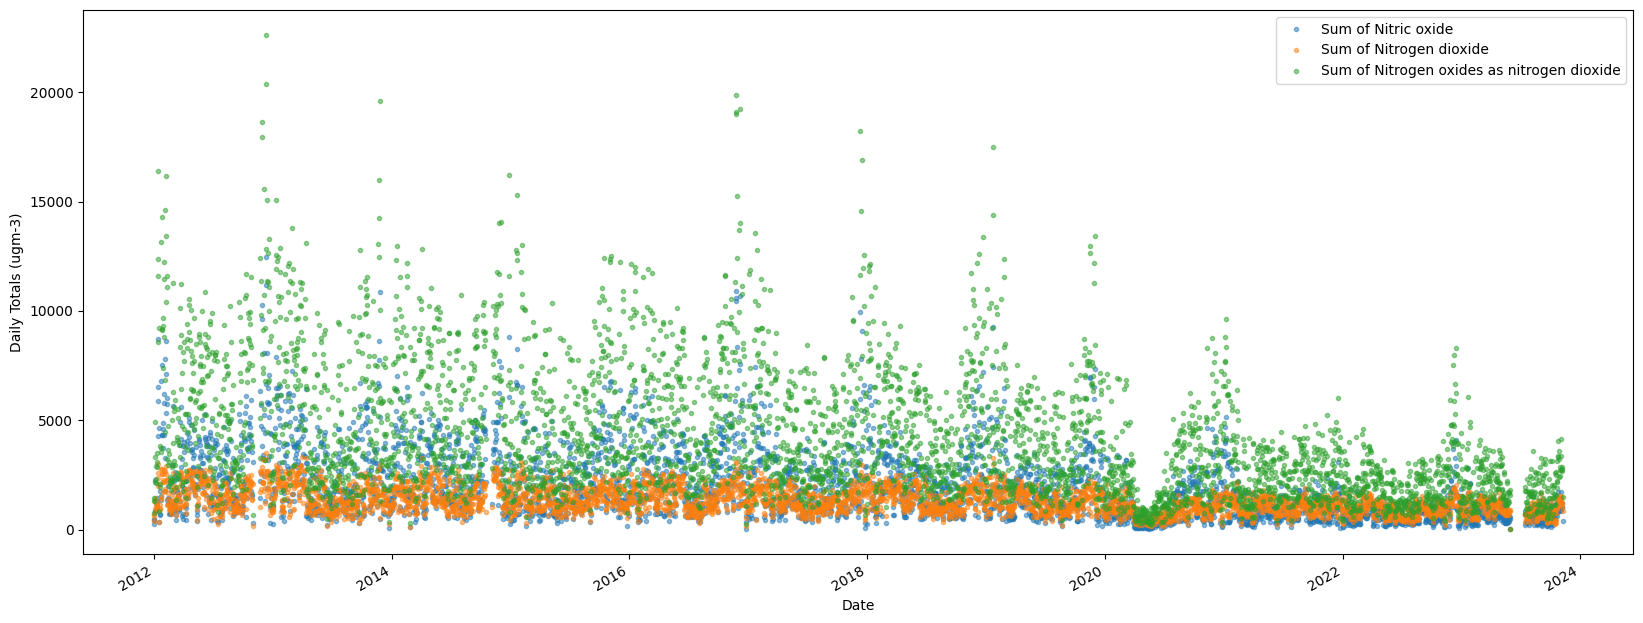

In [6]:
axes = time_series_df.plot(marker='.', alpha=0.5, linestyle='None')
plt.ylabel('Daily Totals (ugm-3)');


## Can we predict each day's consumption from its past?

### We train on the years 2006 - 2016 and validate on 2017

In [7]:
NO = time_series_df['Sum of Nitric oxide'].to_numpy()
NO.shape

(4237,)

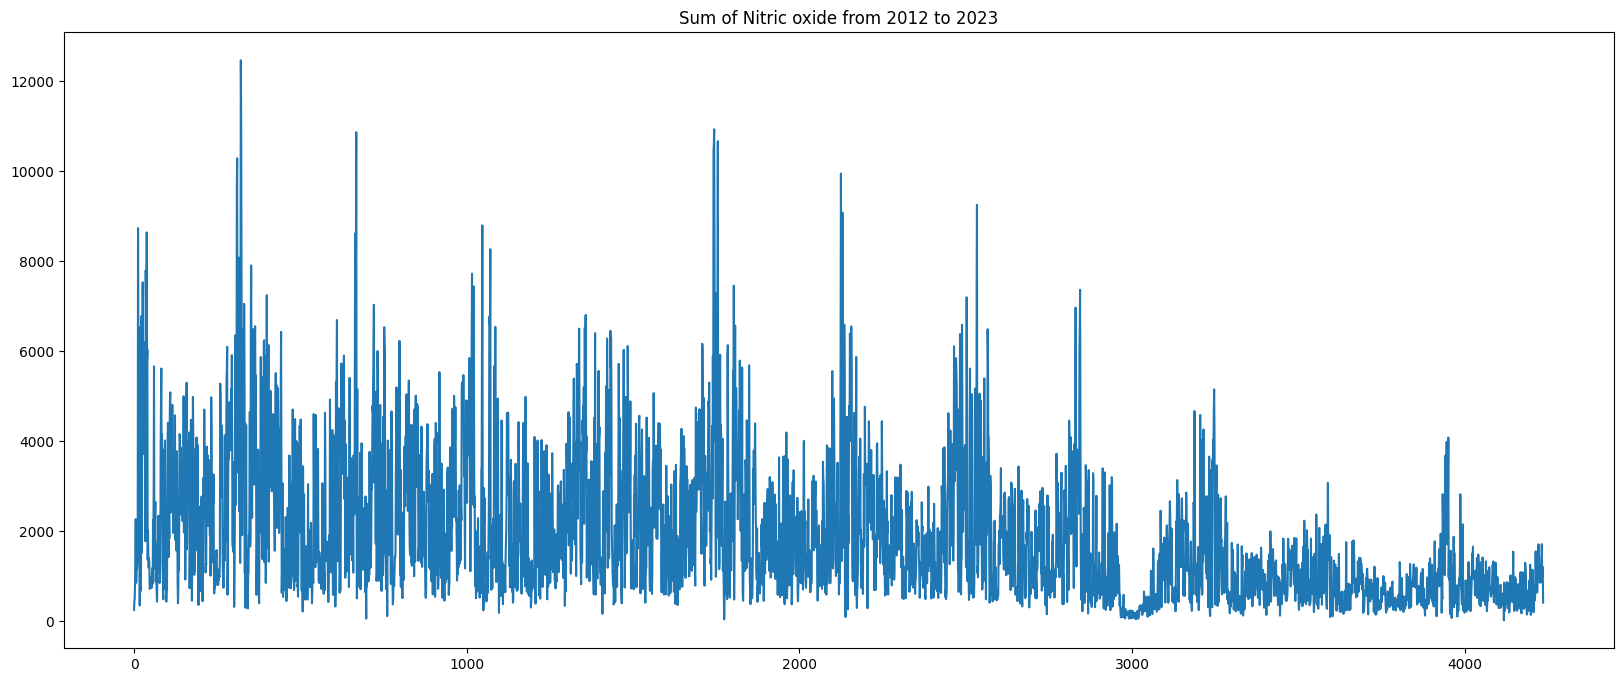

In [9]:
plt.title('Sum of Nitric oxide from 2012 to 2023')
plt.plot(NO);

## Statistical Methods directly geared towards forecasting

_Statistical Methods are often favorable: https://twitter.com/togelius/status/1173272424177119233_

* https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b#targetText=Time%20series%20forecasting%20is%20the,forecasting%20retail%20sales%20time%20series.
* https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* https://research.fb.com/prophet-forecasting-at-scale/

https://www.statsmodels.org
* https://www.statsmodels.org/stable/examples/index.html#stats
* https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html
* https://www.statsmodels.org/stable/tsa.html



<ipython-input-13-bcab1505b761>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  decomposition = sm.tsa.seasonal_decompose(time_series_df['2022']['Sum of Nitric oxide'], model='additive')


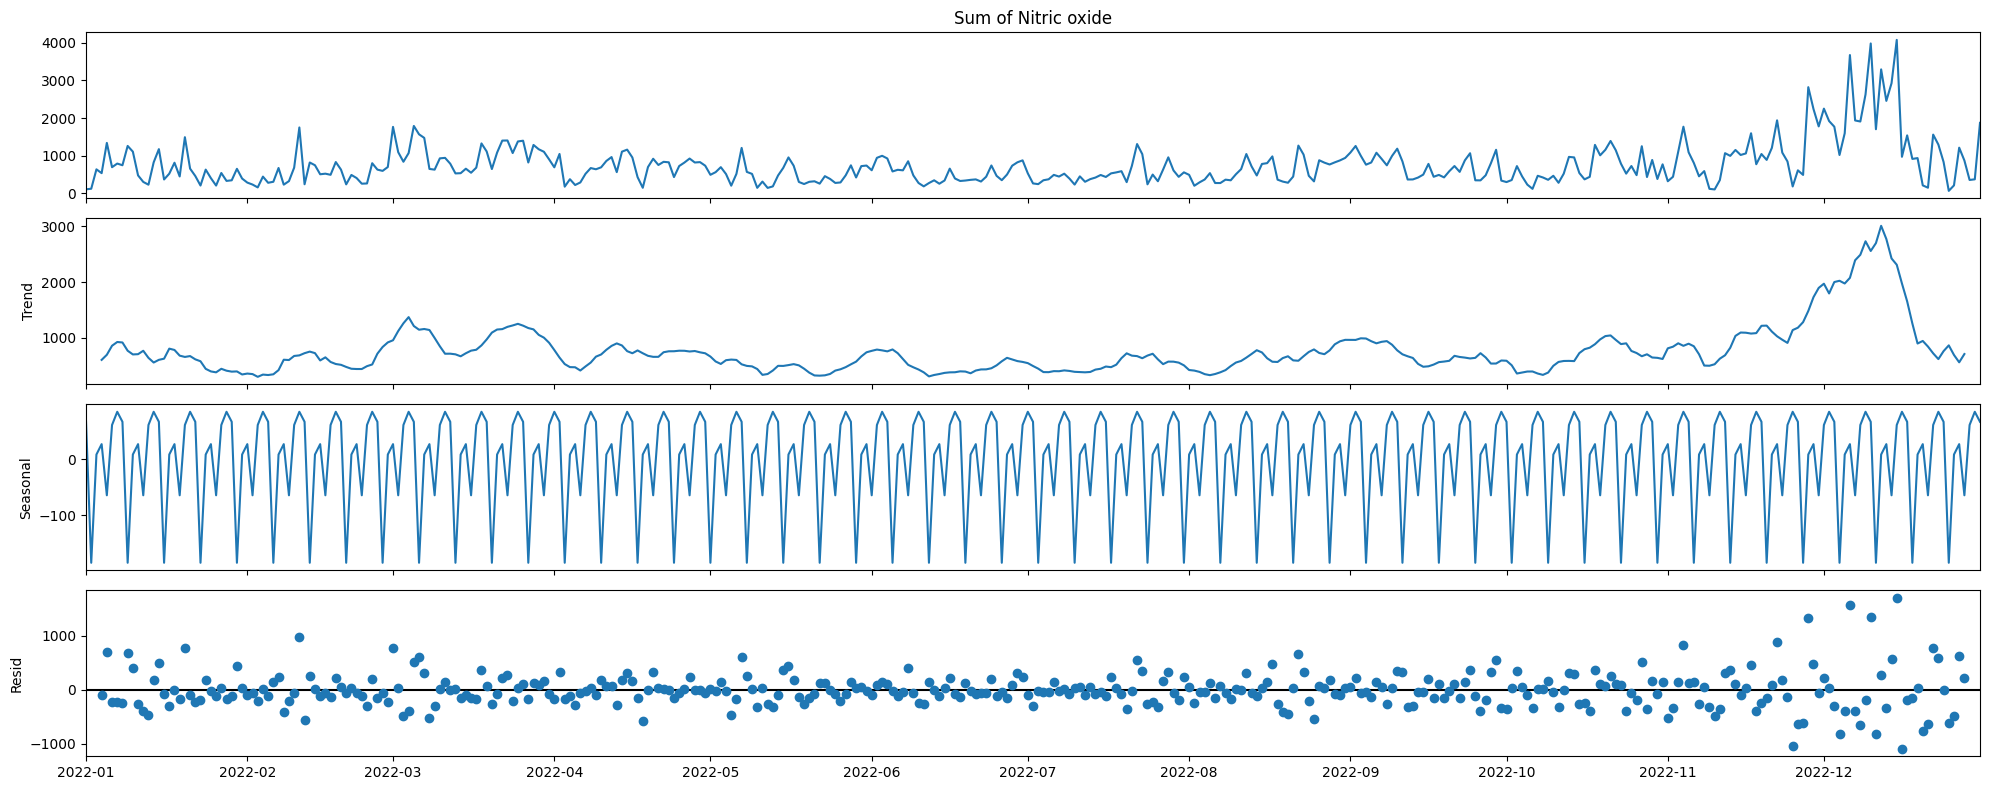

In [13]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(time_series_df['2022']['Sum of Nitric oxide'], model='additive')
decomposition.plot();

In [14]:
# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### How much of the past would we like for each individual prediction?

In [15]:
#@title Prediction from n past days

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps_in = 30 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 1

In [16]:
X, Y = split_sequence(NO, n_steps_in, n_steps_out)
X.shape, Y.shape

((4207, 30), (4207, 1))

In [17]:
X[0], Y[0]

(array([ 246,  452,  492,  827, 1311, 2265,  844,  889, 1201, 1162, 1285,
        1434, 8732, 5899, 4287, 6530, 4642,  343, 1754,  734,  666, 1336,
        6778, 1514, 4327, 4312, 7527, 3711, 4883, 4593]),
 array([6204]))

In [18]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(4207, 30, 1)

In [19]:
# we do a special test / train split,
# we see how well we can predict 2017 as test/validation


X_train = X[:-365]
Y_train = Y[:-365]

X_test = X[-365:]
Y_test = Y[-365:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3842, 30, 1), (3842, 1), (365, 30, 1), (365, 1))

## Baslines

### R2 Metric: MSE and MAE are not speaking

* R^2 score, the closer to 1 the better
* loosely speaking: how much better is this than predicting the constant mean
* 0 would mean just as good
* 1 is perfect
* neg. would mean even worse
* it can become arbitrarily worse

https://en.wikipedia.org/wiki/Coefficient_of_determination


### Rolling mean baseline

In [20]:
def rolling_mean_baseline(history):
  return np.mean(history, axis=1)

In [21]:
Y_pred_baseline_rolling = rolling_mean_baseline(X)
Y_pred_baseline_rolling.shape

(4207, 1)

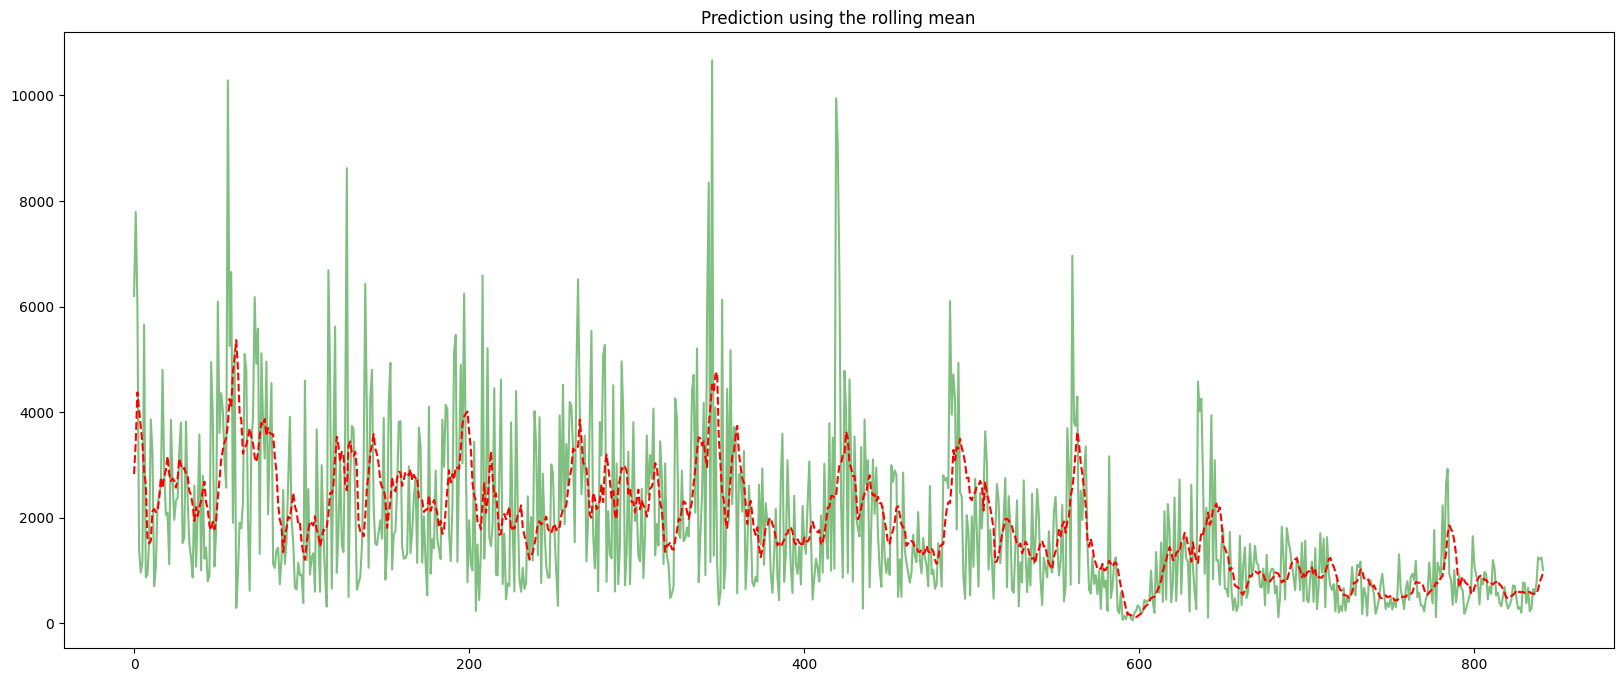

In [22]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(NO[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_rolling[::stride], color='r', ls='dashed')

plt.title('Prediction using the rolling mean');



In [23]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_rolling)

0.2691631298685202

### Baseline: Previous Value

In [24]:
def previous_value_baseline(history):
  return history[:, -1]

In [25]:
Y_pred_baseline_previous_value = previous_value_baseline(X)
Y_pred_baseline_previous_value.shape

(4207, 1)

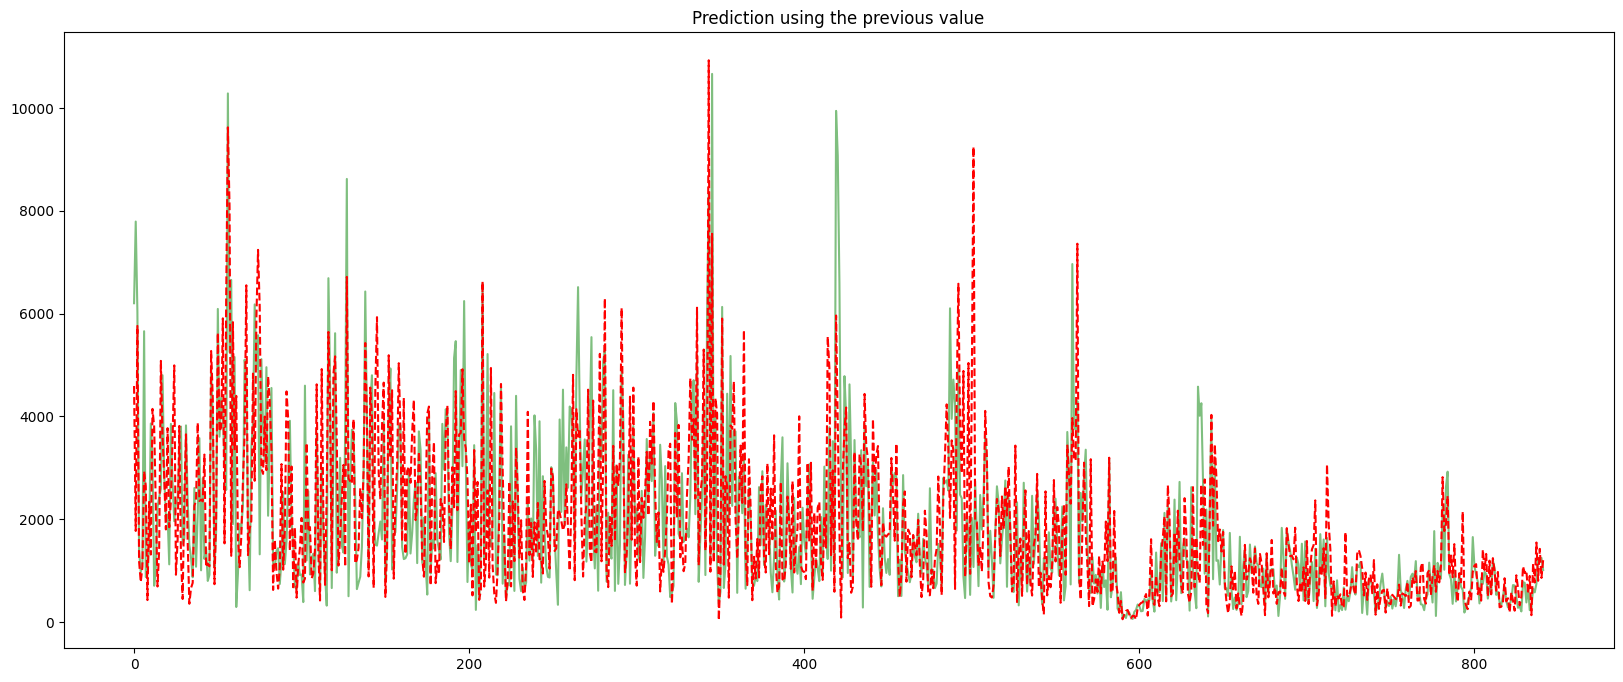

In [26]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(NO[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[::stride], color='r', ls='dashed')
plt.title('Prediction using the previous value');

### This looks good at first sight, but wait for the R2 score

It is (obviously) always off by one

In [27]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_previous_value)

0.31673021916965394

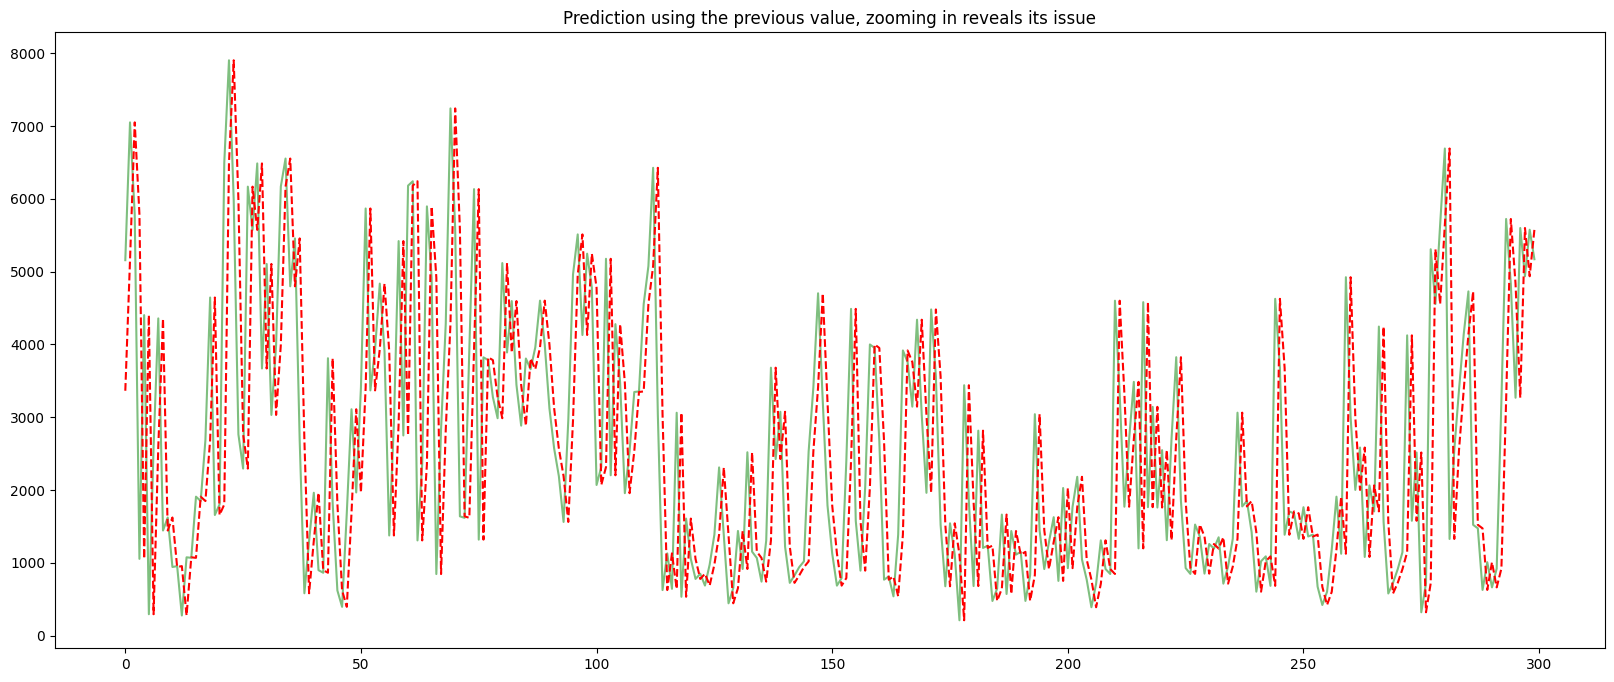

In [28]:
# this gets really crowded, using a stride, makes it more readable
stride = 1
# too crwoded, zoom in
window_start = 300
window_end = 600

plt.plot(NO[n_steps_in+window_start:n_steps_in+window_end:stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[window_start:window_end:stride], color='r', ls='dashed')

plt.title('Prediction using the previous value, zooming in reveals its issue');

## Prediction using RNNs and TensorFlow

### Can we beat an r2 score around .20?

In [29]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [30]:
import tensorflow as tf
print(tf.__version__)

2.14.0


### Just for the reference, what GPU are we running on?

In [31]:
# What kind of GPU are we running on
!nvidia-smi

Sun Nov 12 22:06:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
# adapted from https://stackoverflow.com/a/42351397/1756489 and ported to TF 2
# https://keras.io/metrics/#custom-metrics

# only works on tensors while training, use sklearn version when using on numpy arrays

def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))

  return R_squared

### Training our model

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

model = Sequential()

# two layer model, known to work well
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))

# trains faster, but also works
# model.add(GRU(256, activation='relu', input_shape=(n_steps_in, n_features)))

# one layer SimpleRNN seems to be enough for this data set
model.add(SimpleRNN(256, activation='relu', input_shape=(n_steps_in, n_features)))

# horrible results
# model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(LSTM(64, activation='relu'))

# optional regularization
# model.add(BatchNormalization())
# model.add(Dropout(0.2))


# combines final outputs from RNN into continous output
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 66305 (259.00 KB)
Trainable params: 66305 (259.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
%%time

batch_size = 32
epochs=25

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/25
121/121 [==============================] - 9s 28ms/step - loss: 1746208.3750 - r2_metric: 0.2227 - val_loss: 227095.0312 - val_r2_metric: -0.0537
Epoch 2/25
121/121 [==============================] - 3s 24ms/step - loss: 1478091.5000 - r2_metric: -0.0296 - val_loss: 224997.8906 - val_r2_metric: -0.0076
Epoch 3/25
121/121 [==============================] - 2s 20ms/step - loss: 1473389.7500 - r2_metric: 0.3304 - val_loss: 225417.6875 - val_r2_metric: -0.0156
Epoch 4/25
121/121 [==============================] - 4s 33ms/step - loss: 1427816.0000 - r2_metric: -3.5906 - val_loss: 223191.8281 - val_r2_metric: -0.0065
Epoch 5/25
121/121 [==============================] - 2s 20ms/step - loss: 1438084.1250 - r2_metric: 0.3405 - val_loss: 231674.8750 - val_r2_metric: -0.0620
Epoch 6/25
121/121 [==============================] - 2s 20ms/step - loss: 1463072.0000 - r2_metric: 0.2815 - val_loss: 230387.3750 - val_r2_metric: -0.0652
Epoch 7/25
121/121 [==============================] - 2s

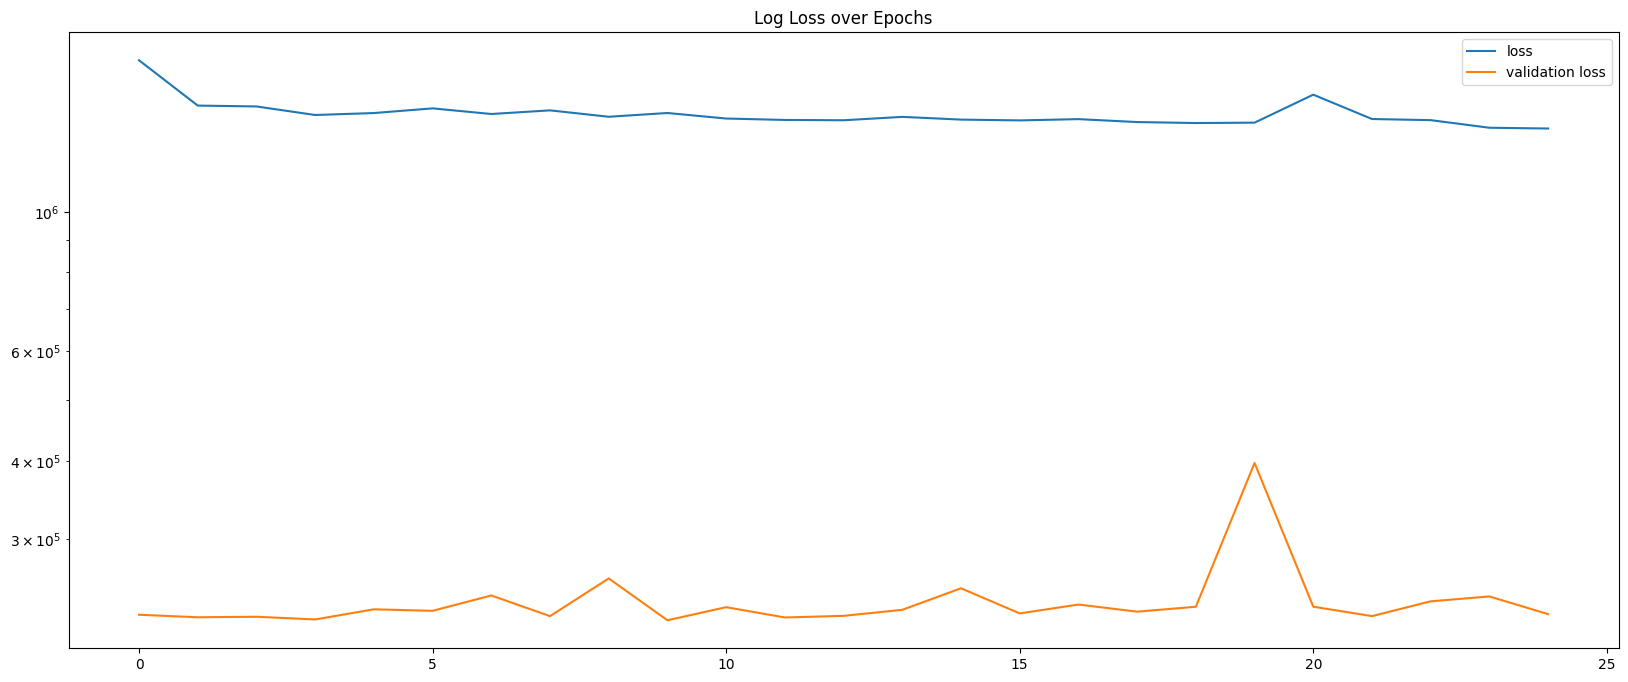

In [35]:
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss']);

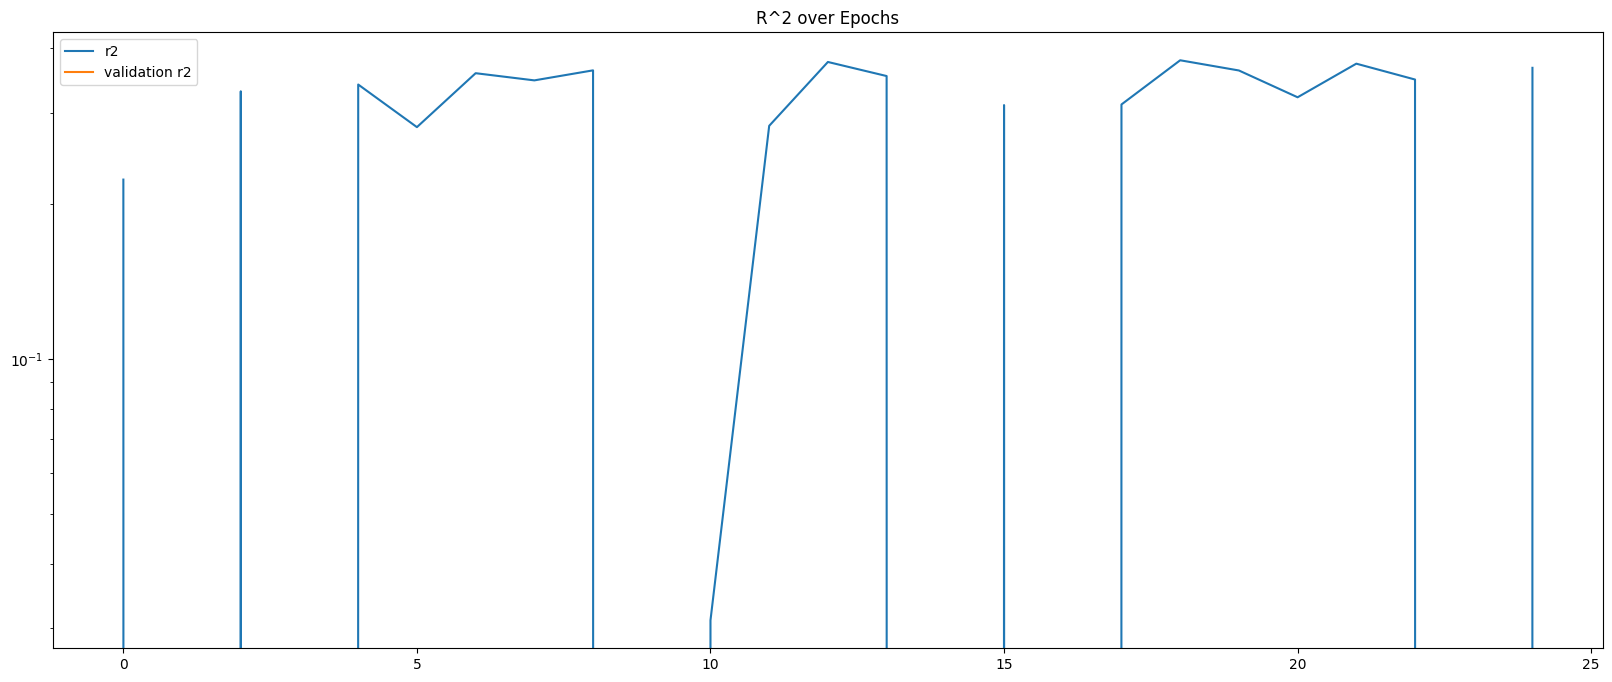

In [36]:
plt.yscale('log')
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('R^2 over Epochs')

plt.legend(['r2', 'validation r2']);

In [37]:
model.evaluate(X, Y, batch_size=batch_size, verbose=0)

[1209095.625, 0.10099002718925476]

### R2 for all data

In [38]:
from sklearn.metrics import r2_score

Y_pred = model.predict(X)
r2_score(Y, Y_pred)

132/132 [==============================] - 1s 4ms/step


0.49581478997373485

### R2 for training data

In [39]:
Y_train_pred = model.predict(X_train)
r2_score(Y_train, Y_train_pred)

121/121 [==============================] - 1s 4ms/step


0.4735153898825444

### R2 for validation data

In [40]:
Y_test_pred = model.predict(X_test)
r2_score(Y_test, Y_test_pred)

12/12 [==============================] - 0s 4ms/step


0.3240453144033766

## Let's plot predicted and true over each other

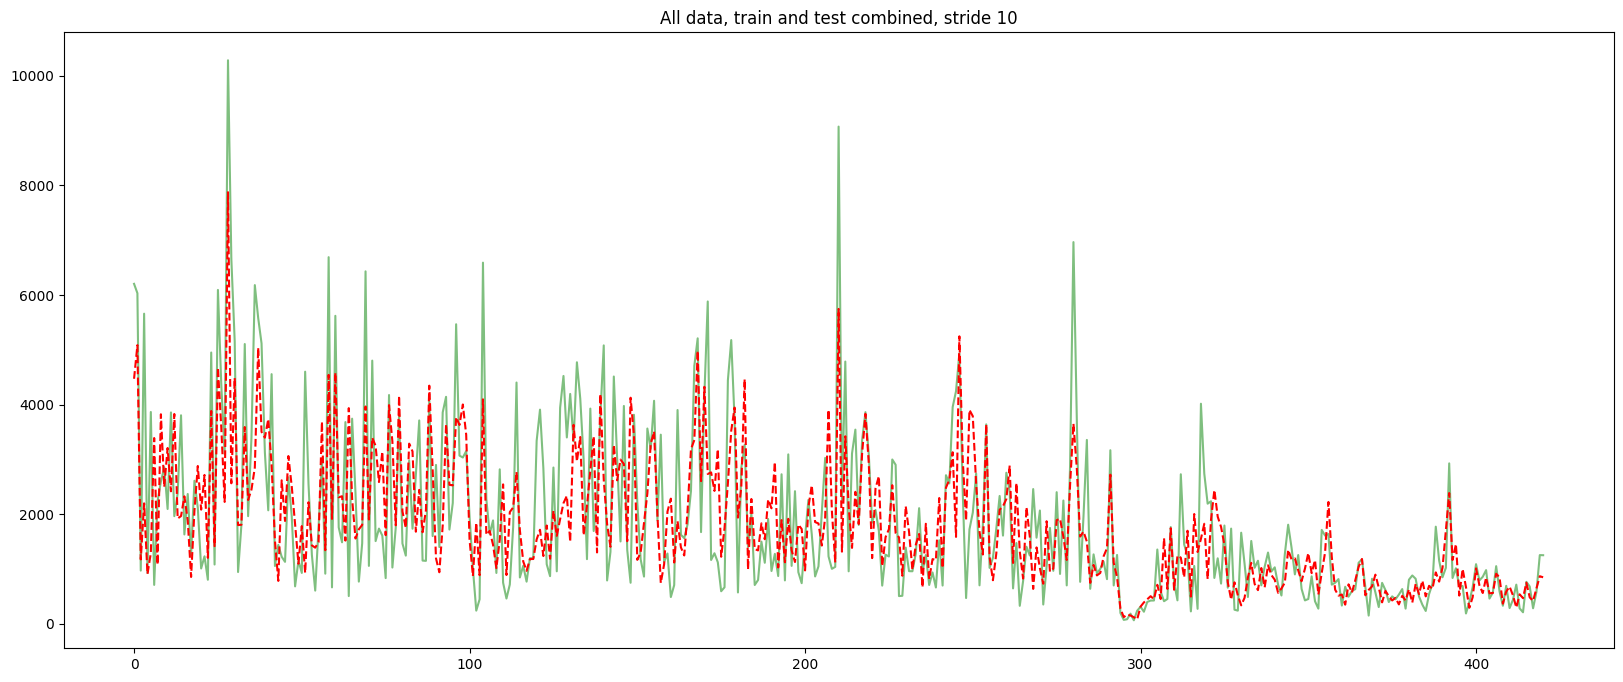

In [41]:
# this gets really crowded, using a stride, makes it more readable
stride = 10

# for the first 90 days we have no prediction, so get rid of them
plt.plot(NO[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred[::stride], color='r', ls='dashed')

plt.title('All data, train and test combined, stride 10');


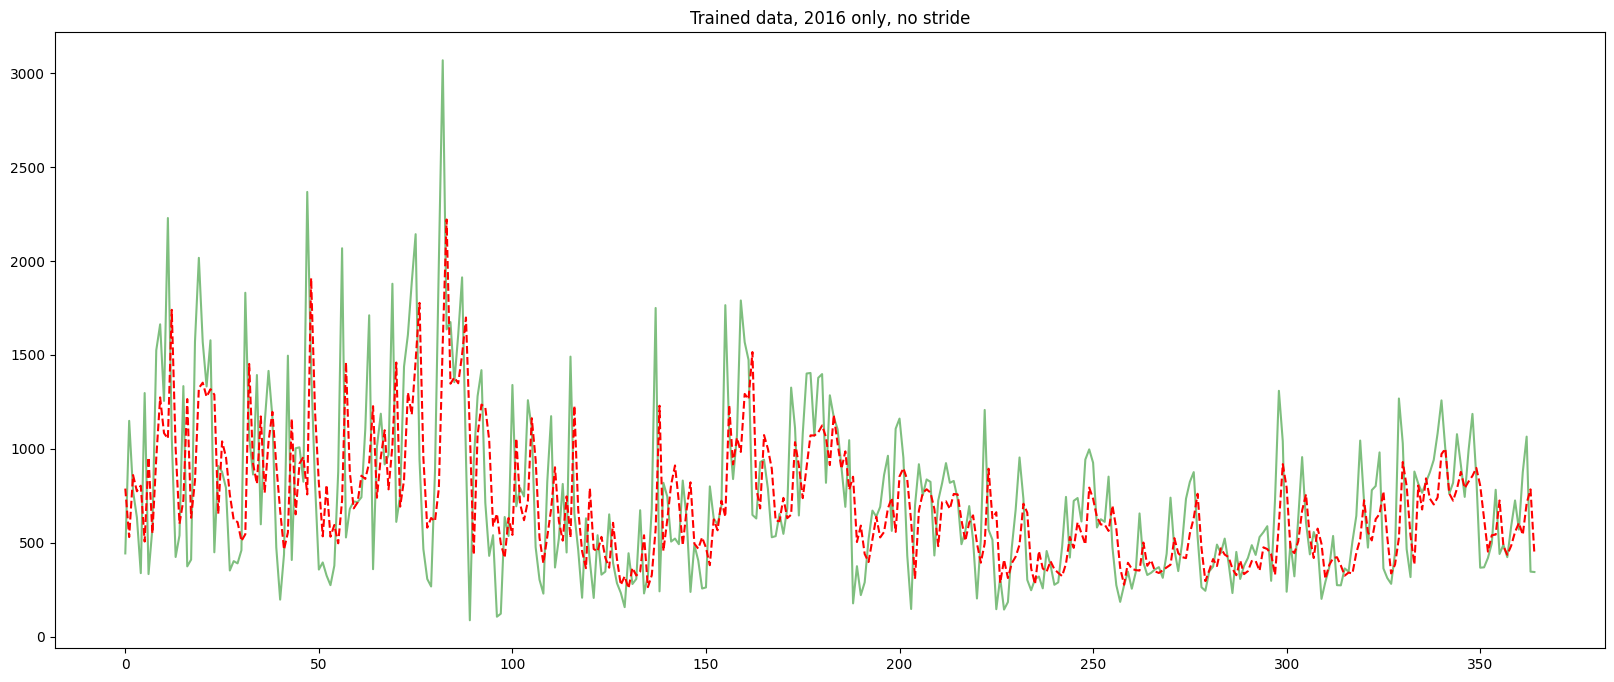

In [43]:
stride = 1


plt.plot(NO[-2 * 365:-365:stride], alpha=0.5, color='g')
plt.plot(Y_train_pred[-365::stride], color='r', ls='dashed')

plt.title('Trained data, 2016 only, no stride');


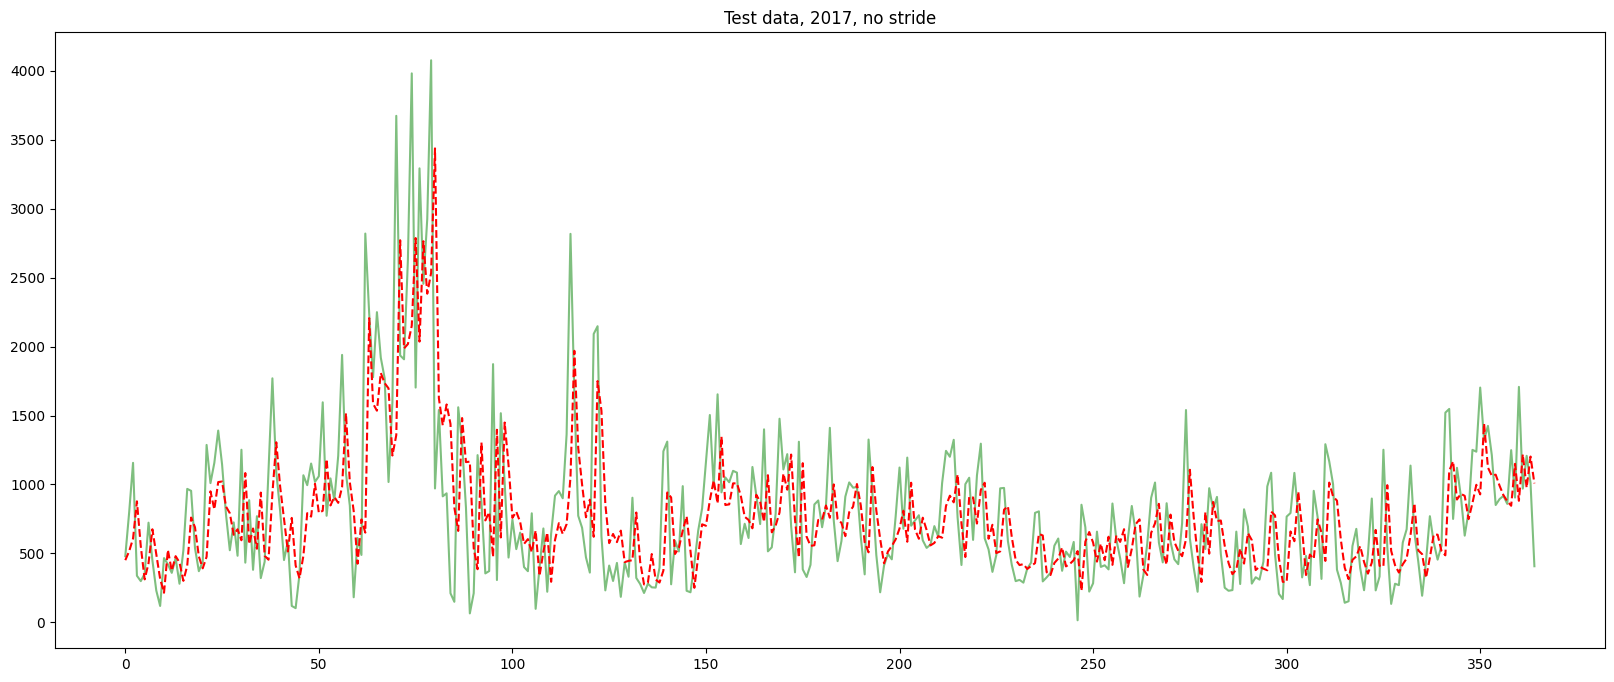

In [42]:
stride = 1


plt.plot(NO[-365::stride], alpha=0.5, color='g')
plt.plot(Y_test_pred[::stride], color='r', ls='dashed')

plt.title('Test data, 2017, no stride');


## Observation / Wrap-Up

### overall a pretty good result
* r2 score is pretty promising
* defintely improved over baseline
* no domain knowledge necessary

### no dramatic difference between training and test data
* neither in metrices
* nor in visual inspection

### peaks and valleys are underestimated very often
* but often the most interesting part
* this seems to be a common problem in time series prediction
* it gets better we train the model for longer
* also when we increase its capacity
* on the other hand this might counter regularization


## Next Steps
  
### make use of seasonal decomposition
* predict each of the components
  * trend should be pretty easy
  * residual shows clear spices on national holidays
  * remove them
  * the results might be noise only
  * but maybe it is not, train a model on it to check
  
### have a more powerful statistical baseline
* Use more powerful statistical models
  * https://www.statsmodels.org/stable/tsa.html
  * http://www.statsmodels.org/dev/tsa.html
  * http://www.statsmodels.org/dev/vector_ar.html
* MSBVAR (Markov-Switching, Bayesian, Vector Autoregression Models) might beat our model, but
  * needs a lot of modelling
  * does not seem readily available in the Python world (in R it would be)
  
